In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ihrem.analysis import prc
from ihrem.timeslice import ms
from ihrem import plot as splot

sampling_period = ms(seconds=.1)


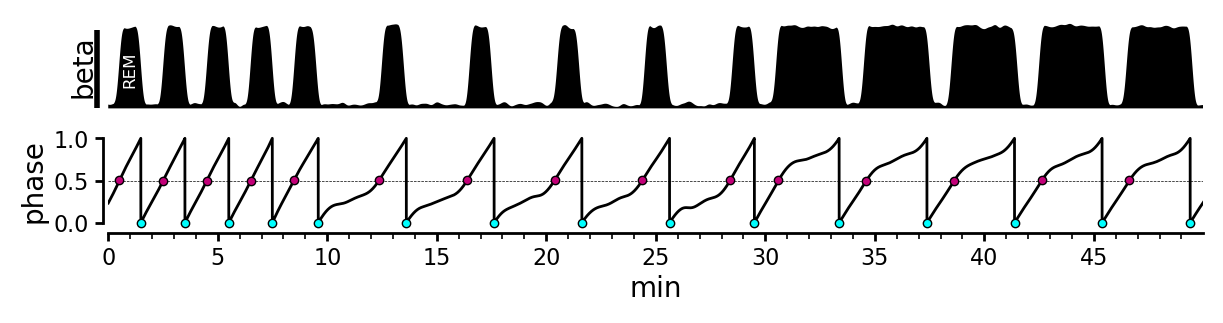

In [3]:
def unbalanced_cycle(rem, sws):
    sws_bit = 0 * np.ones(int(rem // sampling_period))
    rem_bit = 1 * np.ones(int(sws // sampling_period))

    cycle = np.concatenate([sws_bit, rem_bit])

    cycle = pd.Series(
        cycle,
        index=np.arange(0, len(cycle)) * sampling_period
    )
    return cycle


def concat_ts(ts):
    
    ts = np.concatenate([t.values for t in ts])

    ts = pd.Series(
        ts,
        index=np.arange(0, len(ts)) * sampling_period
    )
    return ts


    
def unbalanced_cycles(rem, sws, count):
    cycle = unbalanced_cycle(rem, sws)
    return concat_ts([cycle] * count)


def find_crossings(phase, value):
    crossed = (phase.shift(1) < value) & (value <= phase)
    
    phase_circ = (phase + .5)  % 1
    value_circ = (value + .5)  % 1
    
    crossed_circ = (phase_circ.shift(1) < value_circ) & (value_circ <= phase_circ)
    
    return phase.index[crossed | crossed_circ]


def build_example_trace():
    trace = concat_ts([
        unbalanced_cycles(ms(minutes=1), ms(minutes=1), 6),
        unbalanced_cycles(ms(minutes=3), ms(minutes=1), 5),
        unbalanced_cycles(ms(minutes=1), ms(minutes=3), 6),
    ])
    
    trace = trace + 0.05
    
    
    noise = np.random.normal(size=len(trace), scale=.2)
    
    noise = pd.Series(
        noise,
        index=np.arange(len(noise)) * sampling_period,
    )
    
    noise = noise.rolling(int(ms(seconds=5) / sampling_period), center=True).mean()
    
    trace = trace + noise
    
    trace = trace.rolling(int(ms(seconds=30) / sampling_period), center=True, min_periods=1, win_type='hamming').mean()
    
    trace = trace.dropna()
    
    return trace


def plot_example(trace, phase):
    f, axs = plt.subplots(nrows=2, sharex='all', figsize=(6, 1.5))
    
    ax = axs[0]
    ax.fill_between(
        trace.index,
        np.zeros(len(trace)),
        trace.values,
        facecolor='k'
    )
    
    ax.text(
        ms(minutes=1),
        .5,
        'REM',
        color='w',
        rotation=90,
        zorder=1e6,
        va='center',
        ha='center',
        fontsize=6,
    )
    
    splot.add_yscale_bar(ax, pos=-.01)
    ax.spines['left'].set_position(('outward', 2))
    
    ax.set(ylabel='beta')
    
    
    ax = axs[1]
    ax.axhline(0.5, color='k', linestyle='--', linewidth=.25)
    
    ax.plot(phase, color='k')
    
    splot.drop_spines_grid(axs)
    
    splot.set_time_ticks(ax, scale='minutes', major=ms(minutes=5), minor=ms(minutes=1), lim=(0, trace.index.max()))
    
    ax.set(
        ylabel='phase',
        yticks=[0, .5, 1]
    )
    
    ax.spines['bottom'].set_position(('outward', 2))
    ax.spines['left'].set_position(('outward', 2))
    ax.spines['left'].set_bounds(0, 1)
    
    ts = find_crossings(phase, 0.5)
    ax.scatter(ts, phase.loc[ts], zorder=1e6, color='xkcd:magenta', clip_on=False, edgecolor='k', linewidth=.5)
    
    ts = find_crossings(phase, 0)
    ax.scatter(ts, phase.loc[ts], zorder=1e6, color='xkcd:cyan', clip_on=False, edgecolor='k', linewidth=.5)
    
    
def main():
    trace = build_example_trace()
    phase = prc.get_phase_norm(trace)
    
    
    trace = trace.loc[ms(minutes=2.5):trace.index.max() -ms(minutes=3.5)]
    phase = phase.loc[ms(minutes=2.5):phase.index.max()-ms(minutes=3.5)]
    
    trace.index = trace.index - trace.index.min()
    phase.index = phase.index - phase.index.min()
    
    
    plot_example(trace, phase)


main()